In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb

from IPython.core.pylabtools import figsize
figsize(12, 8)

url = 'training_data_VT2026.csv'
bikes = pd.read_csv(url, na_values='?', dtype={'ID': str}).dropna()

In [76]:
#np.random.seed(0)

trainI = np.random.choice(bikes.shape[0], size=800, replace=False)
trainIndex = bikes.index.isin(trainI)
train = bikes.iloc[trainIndex]
test = bikes.iloc[~trainIndex]

In [81]:
#model_parameters = ['temp', 'humidity', 'hour_of_day', 'summertime']
features = [
    "hour_of_day","day_of_week","month",
    "holiday","weekday","summertime",
    "temp","dew","humidity",
    "precip","snow","snowdepth",
    "windspeed","cloudcover","visibility"
]
X_train = train[features]
Y_train = np.where(train['increase_stock'] == 'high_bike_demand', 1, 0)
X_test = test[features]
Y_test = np.where(test['increase_stock'] == 'high_bike_demand', 1, 0)


# Pipeline = scaling + KNN
model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15))
])

model.fit(X_train, Y_train)

predictions = model.predict(X_test)
print('Confusion matrix:\n')
print(pd.crosstab(predictions, Y_test, rownames=['Predicted'], colnames=['Actual']))

#print(train[model_parameters].head())

Confusion matrix:

Actual       0   1
Predicted         
0          604  77
1           53  66


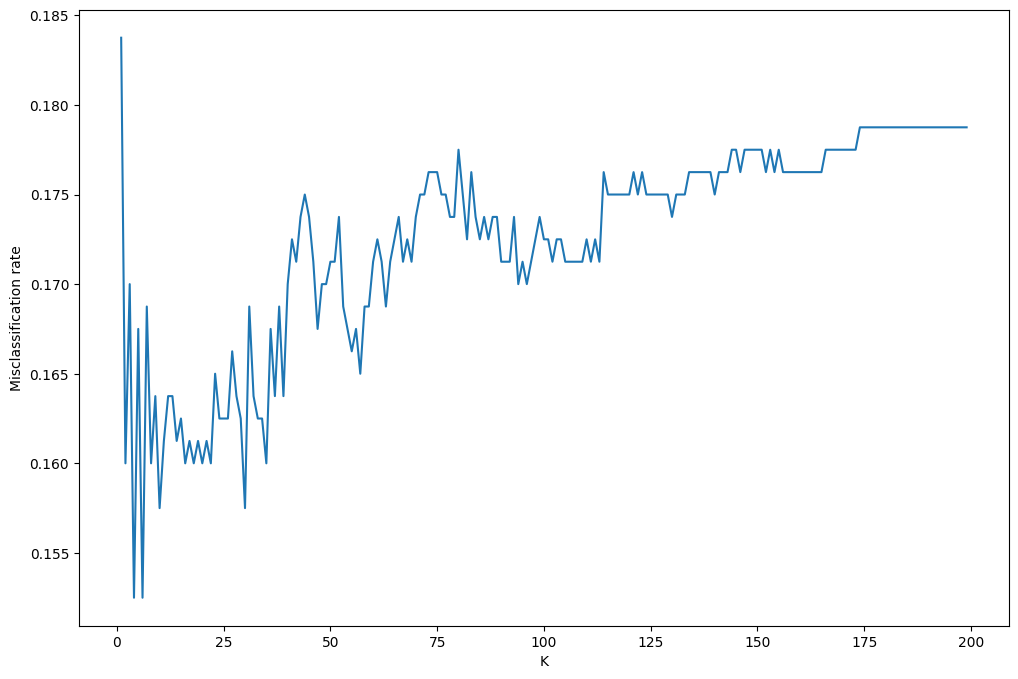

In [82]:
misclassification = []
N = 200
for k in range(1, N):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    misclassification.append(np.mean(predictions != Y_test))

K = np.linspace(1, N-1, N-1)
plt.plot(K, misclassification)
plt.xlabel('K')
plt.ylabel('Misclassification rate')
plt.show()

In [79]:
print(pd.Series(Y_train).value_counts(normalize=True))
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))

0    0.81875
1    0.18125
Name: proportion, dtype: float64
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       657
           1       0.59      0.50      0.54       143

    accuracy                           0.85       800
   macro avg       0.74      0.71      0.72       800
weighted avg       0.84      0.85      0.84       800



Naiv knn väldigt dålig, gör ett antal förbättringar:
scaling, SMOTE oversampling (class imbalance), ANOVA F-test (select non noisy features), GridSearchCV tuning, Distance weighting